# The Glucose Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap06 import *

import pandas as pd

In the previous chapter we implemented the glucose minimal model using given parameters, but I didn't say where those parameters came from.
This notebook solves the mystery.

We'll use a SciPy function called `leastsq`, which stands for "least squares"; that is, it finds the parameters that minimize the sum of squared differences between the results of the model and the data.  This process is sometimes called "fitting": we will "fit" our model to the data.

You can read more about `leastsq` in [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html).  It uses the Levenberg-Marquart algorithm, which you can read about [on Wikipedia](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm).

The following cells download and read the data.

In [2]:
data = pd.read_csv('../Images_and_Data/Data/glucose_insulin.csv', index_col='time');

## Computing errors

In this context, the "errors" are the differences between the results from the model and the data.

To compute the errors, I'll start again with the parameters we used in Chapter 18.

In [3]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05
dt = 2
params = G0,k1,k2,k3, dt

`make_system` takes the parameters and actual data and returns a `System` object.

In [4]:
system = make_system(params, data)

Here's how we run the initial value problem solver.

In [5]:
results, details = run_solve_ivp(system, slope_func, 
                                 t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Because we specify `t_eval=data.index`, the results are evaluated at the same time stamps as the data.

In [6]:
results.tail()

,G,X
102,80.894528,0.003535
122,80.997119,0.001861
142,83.257581,0.000384
162,86.293945,-0.000459
182,89.405110,-0.001178


We can plot the results like this.

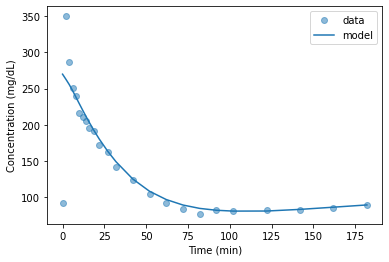

In [7]:
data.glucose.plot(style='o', alpha=0.5, label='data',
                  legend=True)
results.G.plot(style='-', color='C0', label='model',
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)',
              legend=True);

During the first three time steps, the model does not fit the data. That's because it takes some time for the injected glucose to disperse.

We can compute the errors like this.

In [8]:
errors = results.G - data.glucose
errors.head()

0    178.000000
2    -87.019058
4    -31.316545
6     -3.684558
8     -1.728149
dtype: float64

The first few errors are substantially larger than the rest.

In the next section, we'll use `leastsq` to search for the parameters that minimize the sum of the squared errors.

## Optimization

To use `leastsq`, we need an "error function" that takes a sequence of parameters and returns an array of errors.

Here's a function that does what we need.

In [9]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_solve_ivp(system, slope_func, 
                                     t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors.iloc[3:]

`error_func` uses the given parameters to make a `System` object, runs the simulation, and returns the errors.

But notice that it does not return all of the errors; rather, it uses `iloc` to select only the elements with index 3 or more.
In other words, it omits the elements with index 0, 1, and 2.
Note: You can read more about this use of `iloc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

Since we don't expect the model to fit the data in this regime, we'll leave it out.

We can call `error_func` like this:

In [10]:
error_func(params, data)

6      -3.684558
8      -1.728149
10     13.294083
12      9.425807
14      6.752546
16      7.353682
19     -0.610979
22      8.260041
27      0.569221
32      6.984791
42      1.228652
52      3.302437
62      4.855592
72      5.283959
82      7.627294
92      0.046105
102    -0.105472
122    -1.002881
142     1.257581
162     1.293945
182    -0.594890
dtype: float64

Now we're ready to call `leastsq`.  As arguments, we pass `error_func`, the parameters where we want to start the search, and the data, which will be passed as an argument to `error_func`.

In [11]:
best_params, fit_details = leastsq(error_func, params, data)

Each time `error_func` is called, it prints the parameters, so we can get a sense of how `leastsq` works.   Look at one of the printed columns: do you see how it starts at the given value (say, 270 for G0) and then starts to change?   Each line represents another "guess" by the `leastsq` algorithm, and with each guess, it searches out a smaller sum of the squares of the errors.  This process is called *iteration*.

Notice that in the last few iterations, the values of the parameters are changing by miniscule amounts: at this point, the algorithm is narrowing down the values to its final answer, which is the set of parameters that minimize the sum of the squares of the errors.

`leastsq` has two return values.
The first is an array with the best parameters:

In [12]:
best_params

array([2.71947191e+02, 2.42007333e-02, 1.56858708e-02, 1.27588089e-05,
       2.00000000e+00])

The second is an object with information about the results, including a success flag and a message.

In [13]:
fit_details.success

True

In [14]:
fit_details.mesg

'The relative error between two consecutive iterates is at most 0.000000'

This means that the last two iterations produced nearly identical results, and is a sign that the iteration process is complete.

Now that we have `best_params`, we can use it to make a `System` object and run it.

In [15]:
system2 = make_system(best_params, data)
results2, details = run_solve_ivp(system2, slope_func, 
                                  t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Here are the results, along with the data.

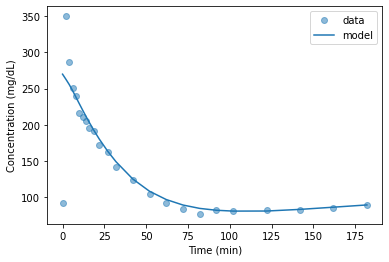

In [16]:
data.glucose.plot(style='o', alpha=0.5, label='data',
                 legend=True)
results.G.plot(style='-', color='C0', label='model',
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)',
              legend=True);

We can compute the errors like this.

In [17]:
errors2 = results2.G - data.glucose
errors2.head()

0    179.947191
2    -86.588650
4    -32.211130
6     -5.659953
8     -4.719719
dtype: float64

Notice that the errors are not zero.  This is because no function of the form that we are using is capable of going through each data point.  The curve is a "best fit", but it is not a *perfect* fit.

The sum of the squared errors like this:

In [18]:
from numpy import sum

sum(errors2.iloc[3:]**2)

319.9426285474499

If things have gone according to plan, the sum of squared errors should be smaller now, compared to the parameters we started with.

In [19]:
sum(errors.iloc[3:]**2)

626.2443450141396

### Exercise 1

How sensitive are the results to the starting guess for the parameters?  

Run through the notebook three more times.  First, change the parameters just by a bit (say, $G0 = 300$ rather than $270$).  Compare your `best_params` and sum of squared erros to the first try.   Then try it one more time, with significantly different initial parameters (say $G0 = 800$).  Finally, change the initial parameters to the `best_params` of your first try (with the slightly changed parameters), and observe the results.

What happens to the `best_params` and overall error (i.e. the sum of squared errors) in each case?

Hint: you test a new set of parameters simply by changing the parameters at the top of the notebook, and running all the cells again.

#### Describe your results here

Even the small changes in the initial parameters produce different results (the large changes probably produced very different `best_params`).  This has to do with the nature of `leastsq`, and with a lot of optimization algorithms.  It's very difficult for an algorithm to differentiate between a *local* minimum and a *true* minimum.  

Imagine you are placed randomly in a spot in the United States, and are asked to find the point of lowest elevation.  If you were lucky enough to be placed on a hillside above Death Valley, this would be easy.   But if you were placed in the Quad Cities, you would probably follow the Mississippi down to New Orleans, and declare you'd found a minimum.

In this case, our initial guess often leads to a local minimum, which might be quite different than the true minimum (and it's hard to know the difference).  Even if we started a new simulation in New Orleans, we still wouldn't find the minimum in Death Valley.
